## Clasificación reviews Amazon

### Índice
- [Imports](#Imports)
- [Lectura documento](#Lectura-documento)
- [Preprocesamiento](#Preprocesamiento)
- [Entrenamiento de los modelos](#Entrenamiento-de-los-modelos)
    - [Regresión logística](#Regresión-logística)
    - [Naïve Bayes Multinomial](#Naive-Bayes-Multinomial)
    - [Redes neuronales](#Redes-neuronales)
    - [Support Vector Machines](#Support-Vector-Machines)
    - [Ensembles OVO | OVA](#Ensembles-OVO-|-OVA)
    - [Ensembles DecisionTree, Bagging, Boosting y Random Forest](#Ensembles-DecisionTree,-Bagging,-Boosting-y-Random-Forest)
- [Resultados](#Resultados)
    

### Imports

In [ ]:
!pip install googletrans==4.0.0-rc1
! pip install langdetect
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import csv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 KB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 KB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 KB 2.2 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17414 sha256=f77a9cf090fccdb08d5576ab784b4bf6b17f1fc0b8797d5157fc721b73bd0a5b
  Stored in directory: /root/.cache/pip/wheels/a9/25/af/715361fa79594524c89c75d293def652045f3fdce6ca398712
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 4.0.0


In [ ]:
!pip install googletrans==4.0.0-rc1
import pandas as pd
from googletrans import Translator
from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Lectura documento

Creamos el csv con los tres productos elegidos inicialmente. Para ello utilizamos la librería BeautifulSoup.

De cada reseña guardamos los siguientes tres atributos: el rating puesto por el usuario, la reseña escrita y el producto al que pertenece.


In [ ]:
import requests
import bs4
from bs4 import BeautifulSoup


headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:100.0) Gecko/20100101 Firefox/100.0',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
    'Accept-Language': 'en-US,en;q=0.5',
    'Accept-Encoding': 'gzip, deflate, br',
    'Connection': 'keep-alive',
    'Upgrade-Insecure-Requests': '1',
    'Cache-Control': 'max-age=0',
    'TE': 'Trailers',
    'Referer': 'https://www.amazon.com/',
    'Sec-Fetch-Dest': 'document',
    'Sec-Fetch-Mode': 'navigate',
    'Sec-Fetch-Site': 'none',
    'Sec-Fetch-User': '?1',
    'Sec-GPC': '1',
}

ratings = []
comments = []
products = []
page_number = 1

for i in range(3):
    page_number = 0
    while True:
        if i == 0:
            url = f'https://www.amazon.com/-/es/product-reviews/B07BVC4KMT/ref=cm_cr_arp_d_viewopt_sr?ie=UTF8&filterByStar=all_stars&reviewerType=all_reviews&pageNumber={page_number}#reviews-filter-bar'
        elif i == 1:
            url = f'https://www.amazon.com/-/es/product-reviews/B07G7FN1CV/ref=cm_cr_arp_d_viewopt_sr?ie=UTF8&filterByStar=all_stars&reviewerType=all_reviews&pageNumber={page_number}#reviews-filter-bar'
        else:
            url = f'https://www.amazon.com/product-reviews/B0107XRQ7E/ref=cm_cr_arp_d_viewopt_sr?ie=UTF8&filterByStar=all_stars&reviewerType=all_reviews&pageNumber={page_number}#reviews-filter-bar'

        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.content, 'html.parser')

        # Check if the response contains a CAPTCHA challenge
        captcha_form = soup.find('form', {'action': '/errors/validateCaptcha'})
        while captcha_form or str(soup.find('title')).find('Page Not Found')==14:
            response = requests.get(url, headers=headers)
            soup = BeautifulSoup(response.content, 'html.parser')
            captcha_form = soup.find('form', {'action': '/errors/validateCaptcha'})
        print(f"Found {len(ratings)} review elements")
        for review in soup.find_all('div', {'data-hook': 'review'}):
            rating = review.find('i', {'data-hook': 'review-star-rating'})
            if rating:
                comment = review.find('span', {'data-hook': 'review-body'})
                if comment and comment.text:
                  ratings.append(float(rating.text[0:3]))
                  comments.append(comment.text.strip())

                  if i == 0:
                    products.append("Pantuflas")
                  elif i == 1:
                    products.append("Gnomo")
                  else:
                    products.append("CabezaCaballo")
        next_button = soup.find('li', {'class': 'a-last'})
        if not next_button:
            break
        page_number += 1

print(f"Found {len(ratings)} review elements")

Found 0 review elements
Found 0 review elements


KeyboardInterrupt: ignored

Convertimos las tres listas obtenidas a un Dataframe para poder trabajar con el con mayor facilidad.

Tras ello, observamos si hemos obtenido una base de datos balanceada mostrando el histograma de el número de reseñas de cada rating. Una base de datos balanceada facilita el correcto aprendizaje de los modelos de clasificación. Una base de datos desbalanceada, por el contrario, requiere de preprocesamiento y no se tiene certeza de que se vayan a obtener buenos resultados (es fácil que el modelo sobreaprenda con la clase mayoritaria).

In [ ]:
import csv
import pandas as pd
import numpy as np

df = pd.DataFrame({
    'ratings':ratings,
    'comment':comments,
    'product': products
})
print(df)
numeroRatings = df.groupby('ratings').count().loc[:, 'product']
print(numeroRatings)

Por último, traducimos las reseñas que no se encuentran en inglés con la librería Translator de googletrans y luego aplicamos stemming y lemmatizing. Algunos comentarios poseen emoticonos, se ha decidido no traducirlos y mostrar únicamente el índice donde se encuentran.

In [ ]:
from googletrans import Translator
from langdetect import detect, LangDetectException
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer



from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

translator = Translator()
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

df.loc[:, 'comment'] = df.loc[:, 'comment'].apply(lambda x: x.lower())

for i, text in enumerate(df['comment']):
    try:
        if detect(text) != 'en':
            try:
                text = translator.translate(text, dest='en').text
                tokens = word_tokenize(text)
                filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
                stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
                lemmatized_tokens = [lemmatizer.lemmatize(token) for token in stemmed_tokens]
                df.loc[i,'comment'] = ' '.join(lemmatized_tokens)
            except:
                print(f'gugul{i}:{text},')
    except LangDetectException as e:
        print(f'nogugul{i}:{text},')

df.to_csv('reviews.csv', sep=';')

Por último creamos un csv con las reviews de un producto auxiliar, seguimos el mismo procedimiento que anteriormente.

In [ ]:
import requests
import bs4
from bs4 import BeautifulSoup

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:100.0) Gecko/20100101 Firefox/100.0',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
    'Accept-Language': 'en-US,en;q=0.5',
    'Accept-Encoding': 'gzip, deflate, br',
    'Connection': 'keep-alive',
    'Upgrade-Insecure-Requests': '1',
    'Cache-Control': 'max-age=0',
    'TE': 'Trailers',
    'Referer': 'https://www.amazon.com/',
    'Sec-Fetch-Dest': 'document',
    'Sec-Fetch-Mode': 'navigate',
    'Sec-Fetch-Site': 'none',
    'Sec-Fetch-User': '?1',
    'Sec-GPC': '1',
}

ratings = []
comments = []
products = []
page_number = 1

for i in ['five_star','one_star','two_star','three_star','four_star']:
    page_number = 0
    while True:
        url = f'https://www.amazon.es/product-reviews/B00NTCH52W/ref=cm_cr_arp_d_viewopt_sr?ie=UTF8&filterByStar={i}&reviewerType=all_reviews&pageNumber={page_number}#reviews-filter-bar'

        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.content, 'html.parser')

        # Check if the response contains a CAPTCHA challenge
        captcha_form = soup.find('form', {'action': '/errors/validateCaptcha'})
        while captcha_form or str(soup.find('title')).find('Page Not Found')==14:
            response = requests.get(url, headers=headers)
            soup = BeautifulSoup(response.content, 'html.parser')
            captcha_form = soup.find('form', {'action': '/errors/validateCaptcha'})
        print(f"{i}Found {len(ratings)} review elements")
        for review in soup.find_all('div', {'data-hook': 'review'}):
            rating = review.find('i', {'data-hook': 'review-star-rating'})
            if rating:
                comment = review.find('span', {'data-hook': 'review-body'})
                if comment and comment.text:
                    if i=='one_star':
                        ratings.append(1)
                    elif i=='two_star':
                        ratings.append(2)
                    elif i=='three_star':
                        ratings.append(3)
                    elif i=='four_star':
                        ratings.append(4)
                    elif i=='five_star':
                        ratings.append(5)
                    comments.append(comment.text.strip())
                    products.append('Pilas')

        # print(str(soup.find('title')).find('Page Not Found')==14)
        # Check if there is a next page of reviews
        next_button = soup.find('li', {'class': 'a-last'})
        if not next_button:
            break
        page_number += 1

print(f"Found {len(ratings)} review elements")

In [ ]:
import csv
import pandas as pd
import numpy as np

df = pd.DataFrame({
    'ratings':ratings,
    'comment':comments,
    'product': products
})
print(df)
numeroRatings = df.groupby('ratings').count().loc[:, 'product']
print(numeroRatings)

In [ ]:
from googletrans import Translator
from langdetect import detect, LangDetectException
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer



from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

translator = Translator()
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

df.loc[:, 'comment'] = df.loc[:, 'comment'].apply(lambda x: x.lower())

for i, text in enumerate(df['comment']):
    try:
        if detect(text) != 'en':
            try:
                text = translator.translate(text, dest='en').text
                tokens = word_tokenize(text)
                filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
                stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
                lemmatized_tokens = [lemmatizer.lemmatize(token) for token in stemmed_tokens]
                df.loc[i,'comment'] = ' '.join(lemmatized_tokens)
            except:
                print(f'gugul{i}:{text},')
    except LangDetectException as e:
        print(f'nogugul{i}:{text},')

df.to_csv('reviews_aux.csv', sep=';')

Una vez obtenidos los asignamos a variable para utilizarlo durante los problemas

In [ ]:
tt = TweetTokenizer()
reviews = pd.read_csv('reviews.csv',';')
test_reviews = pd.read_csv('reviews_aux.csv',';')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
comments = (reviews.loc[:,"comment"])
ratings = reviews.loc[:,"ratings"]

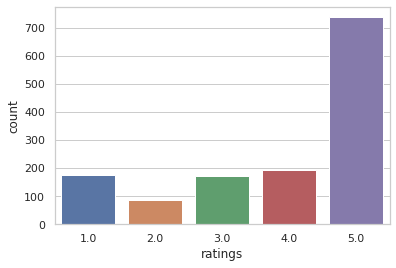

In [ ]:
# Create a seaborn barplot with the count of each value in the variable
sns.countplot(x=reviews['ratings'])


# Show the plot
plt.show()

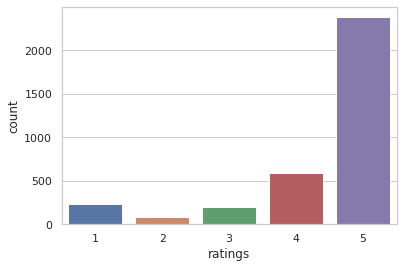

In [ ]:
# Create a seaborn barplot with the count of each value in the variable
sns.countplot(x=test_reviews['ratings'])


# Show the plot
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


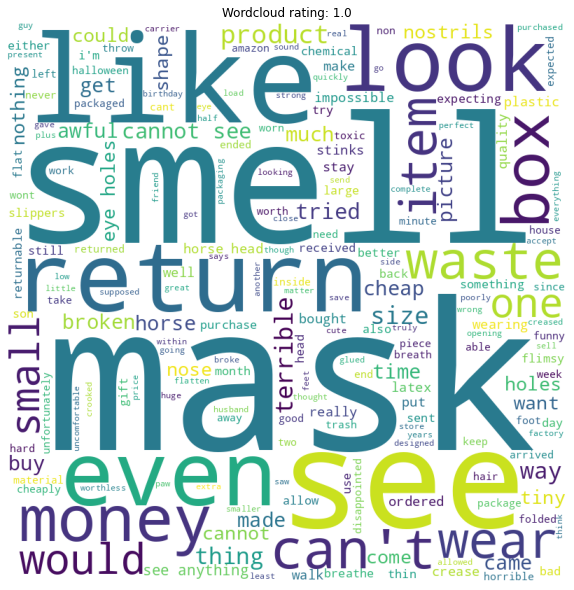

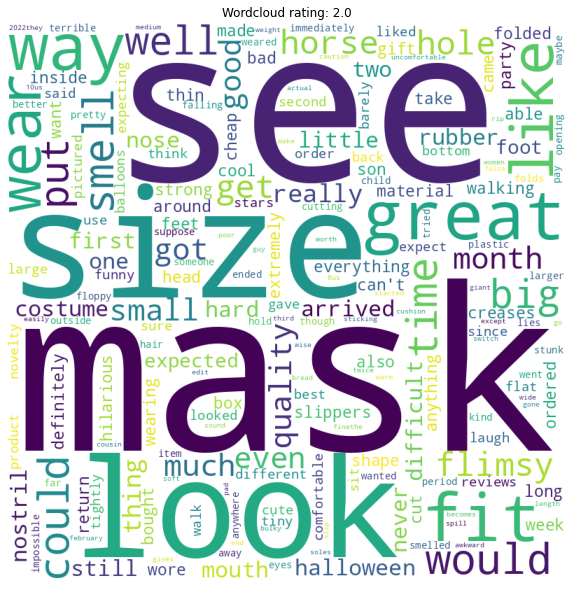

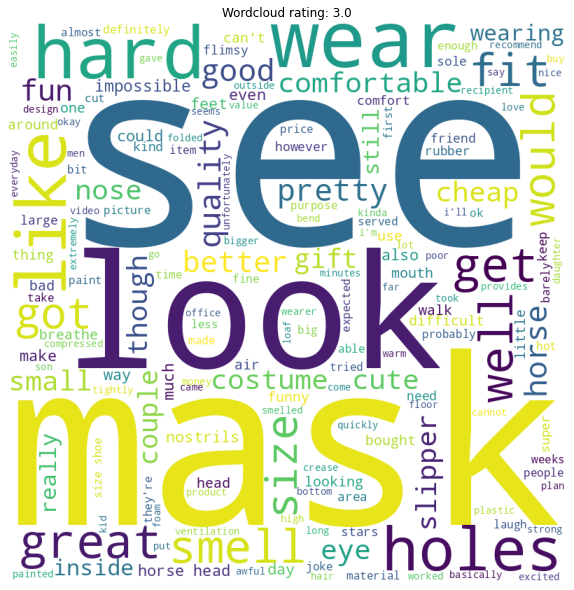

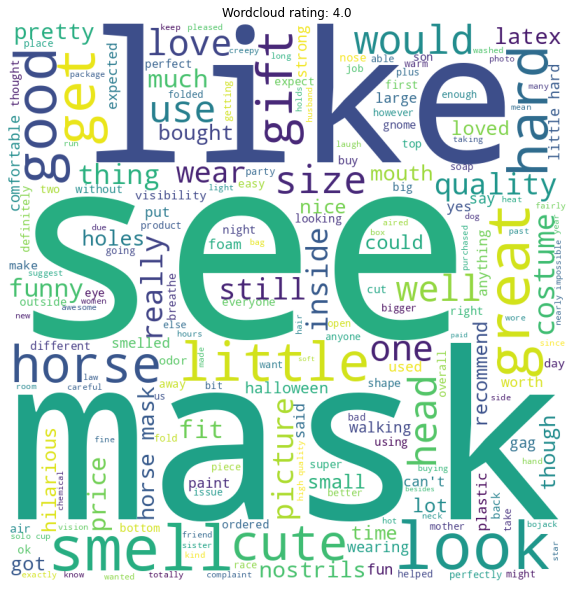

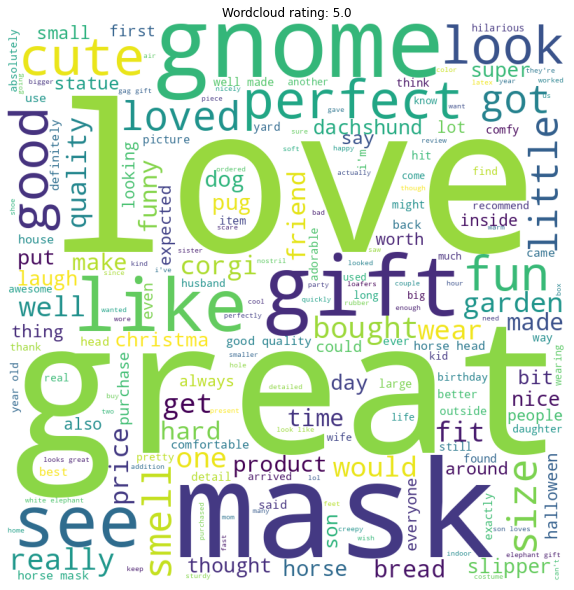

In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stopwords = set(stopwords.words('english'))

# Crear un diccionario vacío para cada clasificación
classification_dict = {1.0: '', 2.0: '', 3.0: '', 4.0: '', 5.0: ''}

# Agregar todas las reseñas clasificadas en cada diccionario
for i, row in reviews.iterrows():
    classification_dict[row['ratings']] += row['comment']

# Crear un wordcloud para cada clasificación
for classification in classification_dict:
    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(classification_dict[classification])

    # Mostrar el wordcloud para cada clasificación
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.title(f"Wordcloud rating: {classification}")
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.show()

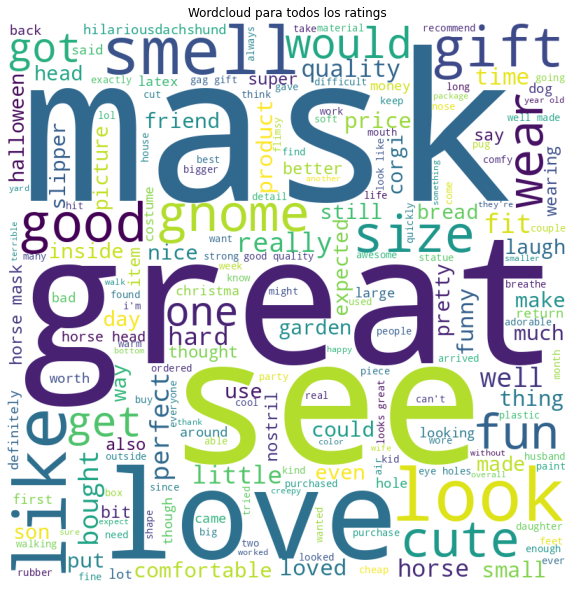

In [ ]:
# Wordcloud para todas las clases
# Comvinamos todas las palabras en un string
all_comments = ' '.join(reviews['comment'].tolist())

wordcloud = WordCloud(width = 800, height = 800,
            background_color ='white',
            stopwords = stopwords,
            min_font_size = 10).generate(all_comments)

# Mostramos el wordcloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.title("Wordcloud para todos los ratings")
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

### Preprocesamiento

**Balanceo de datos de train y validacion**

In [ ]:
# Crear una instancia del objeto Translator
translator = Translator()

# Agrupar los comentarios por clasificación de rating
grupos_clasificacion = reviews.groupby('ratings')

# Iterar sobre cada grupo de comentarios
for clasificacion, grupo in grupos_clasificacion:
    grupo_rating = clasificacion

    # Si la clasificación no es igual a 5
    if grupo_rating !=5:

        # Iterar la mitad de los comentarios en el grupo, usando tqdm para mostrar una barra de progreso
        for i in tqdm(range(int(len(grupo)*0.5))):

            # Continuar intentando traducir un comentario al español hasta que se tenga éxito
            while True:
                try:
                    # Seleccionar un comentario aleatorio del grupo y traducirlo al español
                    translated_comment = translator.translate((grupo.iloc[np.random.randint(len(grupo))].loc["comment"]), dest='es').text

                    # Continuar traduciendo el comentario hasta que esté en inglés
                    while True:
                        try:
                            translated_comment = translator.translate(translated_comment, dest='en').text
                            break
                        except Exception as e:
                            continue

                    # Crear un nuevo comentario con la traducción y la misma clasificación que el grupo original
                    nuevo_comentario = {'comment': translated_comment, 'ratings': grupo_rating}

                    # Añadir el nuevo comentario a la tabla de comentarios original
                    reviews.loc[len(reviews)] = nuevo_comentario

                    # Salir del bucle while si la traducción fue exitosa
                    break

                # Si ocurre un error al intentar traducir un comentario, imprimir el mensaje de error y continuar
                except Exception as e:
                    continue


100%|██████████| 64/64 [00:57<00:00,  1.11it/s]


In [ ]:
from sklearn.utils import resample
import random


df = reviews.copy()
# Separar los datos en clases
clase_mayoritaria = df[df.ratings==5]
clase_minoritaria = df[df.ratings==4]

# Submuestrear la clase mayoritaria
clase_mayoritaria_sub = resample(clase_mayoritaria, replace=False, n_samples=len(clase_minoritaria), random_state=42)

# Combinar las clases submuestreadas
df_sub = pd.concat([df[df.ratings!=5], clase_mayoritaria_sub])
indices = df_sub.index.tolist()

# Mezclar aleatoriamente los índices
random.shuffle(indices)

# Reordenar las filas del DataFrame con los índices mezclados
df_sub = df_sub.loc[indices]
comments = (df_sub.loc[:,"comment"])
ratings = df_sub.loc[:,"ratings"]

# Asignar los datos
Xtrain, ytrain = comments, ratings

### Submuestra de los datos de test

In [ ]:
print(df_sub.groupby('ratings').count())

df = test_reviews.copy()

clase_mayoritaria = df[df.ratings==5]
clase_minoritaria = df[df.ratings==4]

clase_mayoritaria_sub = resample(clase_mayoritaria, replace=False, n_samples=len(clase_minoritaria), random_state=42)

# Combinar las clases submuestreadas
df_sub = pd.concat([df[df.ratings!=5], clase_mayoritaria_sub])
indices = df_sub.index.tolist()

# Mezclar aleatoriamente los índices
random.shuffle(indices)

# Reordenar las filas del DataFrame con los índices mezclados
df_sub = df_sub.loc[indices]
comments = (df_sub.loc[:,"comment"])
ratings = df_sub.loc[:,"ratings"]

# Asignar los datos
Xtest, ytest = comments, ratings

         Unnamed: 0  comment  product
ratings                              
1.0             116      174      116
2.0              58       87       58
3.0             115      172      115
4.0             128      192      128
5.0             192      192      192


<AxesSubplot:xlabel='ratings', ylabel='count'>

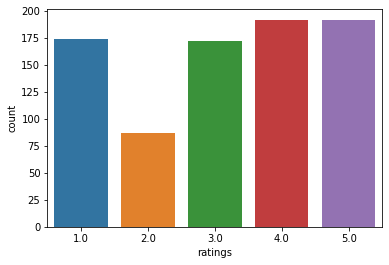

In [ ]:
sns.countplot(x=ytrain)

<AxesSubplot:xlabel='ratings', ylabel='count'>

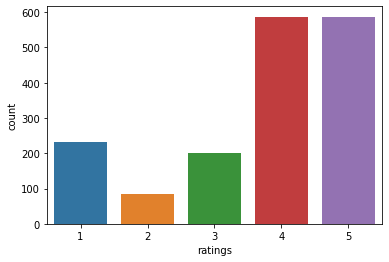

In [ ]:
sns.countplot(x=ytest)

### Visualización de las frecuencias de la palabras más frecuentes en un corpus de texto con CountVectorizer

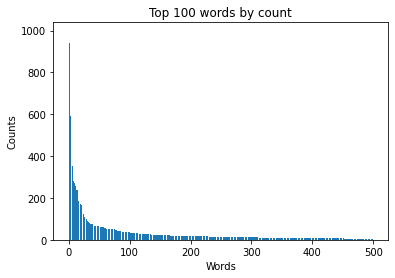

In [ ]:
# example text corpus
corpus = Xtrain

# create CountVectorizer object
vectorizer = CountVectorizer()

# fit and transform the CountVectorizer
count_matrix = vectorizer.fit_transform(corpus)

# convert the count matrix to an array and then to a list of tuples
word_counts = list(zip(vectorizer.get_feature_names_out(), count_matrix.sum(axis=0).tolist()[0]))

# sort the list of tuples in descending order by count value
word_counts = sorted(word_counts, key=lambda x: x[1], reverse=True)

# extract the top 10 words and their counts
top_words = word_counts[:500]
words = [w[0] for w in top_words]
counts = [w[1] for w in top_words]

max_df = [counts[5], counts[7], counts[9], counts[15]]
min_df = [counts[70], counts[100], counts[120], counts[150], counts[250]]

# create a bar graph
plt.bar(np.arange(500), counts)
plt.title('Top 100 words by count')
plt.xlabel('Words')
plt.ylabel('Counts')
plt.show()

### Definicion de una medida de acierto especifica para el problema

In [ ]:
from sklearn.metrics import make_scorer

def custom_accuracy(y_true, y_pred):
    """
    Calculates accuracy where exact matches count as 1,
    adjacent matches count as 0.5, and all other matches count as 0.
    """
    score = 0
    for true, pred in zip(y_true, y_pred):
        if true == pred:
            score += 1
        elif abs(true - pred) == 1:
            score += 0.5
    return score / len(y_true)

custom_scorer = make_scorer(custom_accuracy)

### Entrenamiento de los modelos

#### Regresión Lineal

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
import pandas as pd

# Define the vectorizers to be used
tokenizers = [CountVectorizer, TfidfVectorizer]

# Initialize an empty list to store the accuracy results
maeTest = []

# Loop through the tokenizers
for tokenizer in tokenizers:
    # Define the pipeline
    modelo = Pipeline([('tokenizer', tokenizer()), ('modelo', LinearRegression())])

    # Define the hyperparameters to be tuned
    param_grid = {'tokenizer__max_df': max_df, 'tokenizer__min_df': min_df}

    # Perform grid search with 4-fold cross validation to find the best hyperparameters
    modelos = GridSearchCV(modelo, param_grid, scoring='neg_root_mean_squared_error', cv=4, refit=True, return_train_score=True, n_jobs=-1)
    modelos.fit(Xtrain, ytrain)

    # Evaluate the model on the test set and append the result to the accuracy list
    maeTest.append(mean_absolute_error(ytest, aux:=modelos.predict(Xtest.astype(str))))
    tabla = pd.DataFrame({
        'original':ytest,
        'predict':aux,
        'rounded':np.round(aux),
        'trim':aux.astype(np.uint8)
    })
    tolerance=0.5
    tolerance2=1.5
    # Calculate the percentage of values that fall within the tolerance threshold
    accuracy = ((np.abs(tabla['original'] - tabla['predict']) < tolerance).sum()*0.5 / len(ytest)) * 100 + ((np.abs(tabla['original'] - tabla['predict']) < tolerance2).sum()*0.5 / len(ytest)) * 100

    # Print the accuracy
    print(f"Accuracy: {accuracy:.2f}%")


    # Calculate accuracy for 'rounded'
    rounded_acc = ((tabla['original'] == tabla['rounded'])).sum()*0.5 / len(tabla) * 100 + (abs(tabla['original'] - tabla['rounded']) <= 1).sum()*0.5 / len(tabla) * 100
    print(f"Accuracy for 'rounded': {rounded_acc:.2f}%")

    # Calculate accuracy for 'trim'
    trim_acc = ((tabla['original'] == tabla['trim'])).sum()*0.5 / len(tabla) * 100 + (abs(tabla['original'] - tabla['trim']) <= 1).sum()*0.5 / len(tabla) * 100
    print(f"Accuracy for 'trim': {trim_acc:.2f}%")

# Create a pandas dataframe to display the results
columnNames = ['TfidfVectorizer', 'CountVectorizer']

dataPanda = pd.DataFrame(data=np.array(maeTest).reshape(1, 2), index=['Mean Absolute Error'], columns=columnNames)
dataPanda.index.name = 'Evaluation Metric'
print(dataPanda)

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted labels from the model
y_pred = modelos.predict(Xtest.astype(str))
y_pred[y_pred > 5] = 5
y_pred[y_pred < 1] = 1

# Calculate the confusion matrix
cm = confusion_matrix(ytest, np.round(y_pred))

# Plot the confusion matrix
sns.heatmap(cm, cmap = "coolwarm", annot = True, fmt = 'g', xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.title('Matriz de confusión: Regresión Lineal')
plt.xlabel('Valor predicho')
plt.ylabel('Valor real')


NameError: ignored

Text(33.0, 0.5, 'Valor real')

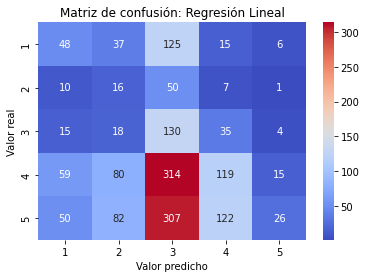

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(ytest, y_pred.astype(np.uint8))

# Plot the confusion matrix
sns.heatmap(cm, cmap = "coolwarm", annot = True, fmt = 'g', xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.title('Matriz de confusión: Regresión Lineal')
plt.xlabel('Valor predicho')
plt.ylabel('Valor real')


In [ ]:
# Gráfica matriz de confusión Regresion lineal  en porcentajes
cm_percent = np.round(cm / cm.sum(axis=1)[:, np.newaxis] * 100, 2)

sns.set(font_scale = 1, color_codes = True, palette = 'deep')
sns.heatmap(cm_percent, cmap = "coolwarm", annot = True, fmt = 'g', xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.title('Matriz de confusión: Regresión Logística')
plt.xlabel('Valor predicho')
plt.ylabel('Valor real')

In [ ]:
# Creamos una lista con las precisiones de todos los clasificadores para representarlas más adelante
precisiones_count = []
precisiones_tfidf = []

#### Regresión Logística

In [ ]:
from sklearn.linear_model import LogisticRegression

tokenizers = [CountVectorizer,TfidfVectorizer]
accTest = []

for tokenizer in tokenizers:
    modelo = Pipeline([('tokenizer', tokenizer()), ('modelo', LogisticRegression(penalty = 'l2', max_iter = 400))])
    # Se define el grid de parámetros a utilizar
        # Estos parámetros nos darán todas las posibles configuraciones del modelo
            # Cada combinación de híper-parámetros es una configuración diferente
    param_grid = {'tokenizer__max_df': max_df, 'tokenizer__min_df': min_df, 'modelo__C': 1/np.geomspace(0.00001, 1000, num=10), 'modelo__solver':['newton-cg', 'saga', 'lbfgs']}
    modelos = GridSearchCV(modelo, param_grid, scoring = 'f1_macro', cv = 4, refit = True, return_train_score = True, n_jobs = -1)
    modelos.fit(Xtrain, ytrain)

    accTest.append(custom_accuracy(ytest, modelos.predict(Xtest.astype(str))))

# Crear una tabla panda para mostrarlo (lo vimos en la práctica de evaluación de modelos)
nombreColumnas = ['CountVectorizer', 'TfidfVectorizer']

datosPanda = pd.DataFrame(data=np.array(accTest).reshape(1, 2), index=['Precisiones'], columns=nombreColumnas)
# Establecemos el nombre de la columna index (valores de lambda)
datosPanda.index.name = 'Precisiones obtenidas'
# Mostramos el dataframe generado
print(datosPanda)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


                       CountVectorizer  TfidfVectorizer
Precisiones obtenidas                                  
Precisiones                   0.461266         0.426079


In [ ]:
# Se muestra la mejor configuración y su accuracy asociado
print(modelos.best_params_)
print(modelos.best_score_)

# Almacenamos el DataFrame con los resultados
diccionarioResultados = modelos.cv_results_
# Se muestra el accuracy obtenido para cada posible combinación de parámetros
resultadosMostrar = zip(diccionarioResultados['params'],diccionarioResultados['mean_test_score'],diccionarioResultados['mean_train_score'])
for params, mean_test_score, mean_train_score in resultadosMostrar:
    print("%0.3f (Train: %0.3f) for %r" % (mean_test_score, mean_train_score, params))
    print()

# Se obtiene el rendimiento en test por la mejor configuración
print(f'La mejor precisión obtenida es: {np.max(accTest)} utilizando el tokenizador: {nombreColumnas[np.argmax(accTest)]}')
precisiones_count.append(accTest[0])
precisiones_tfidf.append(accTest[1])

{'modelo__C': 27.825594022071257, 'modelo__solver': 'newton-cg', 'tokenizer__max_df': 323, 'tokenizer__min_df': 14}
0.4891700150037436
0.351 (Train: 0.458) for {'modelo__C': 99999.99999999999, 'modelo__solver': 'newton-cg', 'tokenizer__max_df': 378, 'tokenizer__min_df': 51}

0.375 (Train: 0.581) for {'modelo__C': 99999.99999999999, 'modelo__solver': 'newton-cg', 'tokenizer__max_df': 378, 'tokenizer__min_df': 35}

0.359 (Train: 0.631) for {'modelo__C': 99999.99999999999, 'modelo__solver': 'newton-cg', 'tokenizer__max_df': 378, 'tokenizer__min_df': 30}

0.403 (Train: 0.742) for {'modelo__C': 99999.99999999999, 'modelo__solver': 'newton-cg', 'tokenizer__max_df': 378, 'tokenizer__min_df': 24}

0.446 (Train: 0.979) for {'modelo__C': 99999.99999999999, 'modelo__solver': 'newton-cg', 'tokenizer__max_df': 378, 'tokenizer__min_df': 14}

0.365 (Train: 0.467) for {'modelo__C': 99999.99999999999, 'modelo__solver': 'newton-cg', 'tokenizer__max_df': 323, 'tokenizer__min_df': 51}

0.373 (Train: 0.578

Text(30.5, 0.5, 'Valor real')

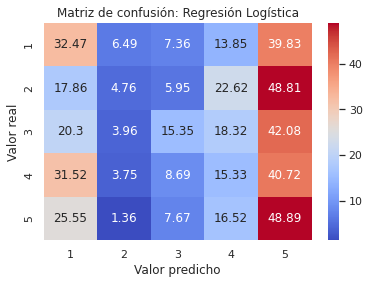

In [ ]:
# Gráfica matriz de confusión Regresion  en porcentajes
cm = metrics.confusion_matrix(ytest,modelos.predict(Xtest.astype(str)))
cm_percent = np.round(cm / cm.sum(axis=1)[:, np.newaxis] * 100, 2)

sns.set(font_scale = 1, color_codes = True, palette = 'deep')
sns.heatmap(cm_percent, cmap = "coolwarm", annot = True, fmt = 'g', xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.title('Matriz de confusión: Regresión Logística')
plt.xlabel('Valor predicho')
plt.ylabel('Valor real')


Text(30.5, 0.5, 'Valor real')

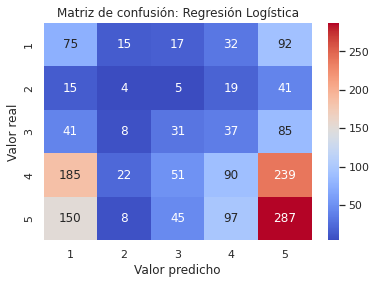

In [ ]:
# Gráfica matriz de confusión Regresion Logística

sns.set(font_scale = 1, color_codes = True, palette = 'deep')
sns.heatmap(cm, cmap = "coolwarm", annot = True, fmt = 'g',xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.title('Matriz de confusión: Regresión Logística')
plt.xlabel('Valor predicho')
plt.ylabel('Valor real')

#### Naïve Bayes Multinomial

In [ ]:
from sklearn.naive_bayes import MultinomialNB

tokenizers = [TfidfVectorizer, CountVectorizer]
accTest = []
for tokenizer in tokenizers:
    modelo = Pipeline([('tokenizer', tokenizer()), ('modelo', MultinomialNB())])
    # Se define el grid de parámetros a utilizar
        # Estos parámetros nos darán todas las posibles configuraciones del modelo
            # Cada combinación de híper-parámetros es una configuración diferente
    param_grid = {'tokenizer__max_df': max_df, 'tokenizer__min_df': min_df}
    modelos = GridSearchCV(modelo, param_grid, scoring = 'f1_macro', return_train_score = True)
    modelos.fit(Xtrain, ytrain)

    accTest.append(custom_accuracy(ytest, modelos.predict(Xtest.astype(str))))

# Crear una tabla panda para mostrarlo (lo vimos en la práctica de evaluación de modelos)
nombreColumnas = ['TfidfVectorizer', 'CountVectorizer']

datosPanda = pd.DataFrame(data=np.array(accTest).reshape(1, 2), index=['Precisiones'], columns=nombreColumnas)
# Establecemos el nombre de la columna index (valores de lambda)
datosPanda.index.name = 'Precisiones obtenidas'
# Mostramos el dataframe generado
print(datosPanda)

                       TfidfVectorizer  CountVectorizer
Precisiones obtenidas                                  
Precisiones                   0.553814         0.540804


In [ ]:
# Se muestra la mejor configuración y su accuracy asociado
print(modelos.best_params_)
print(modelos.best_score_)
# Almacenamos el DataFrame con los resultados
diccionarioResultados = modelos.cv_results_
# Se muestra el accuracy obtenido para cada posible combinación de parámetros
resultadosMostrar = zip(diccionarioResultados['params'],diccionarioResultados['mean_test_score'],diccionarioResultados['mean_train_score'])
for params, mean_test_score, mean_train_score in resultadosMostrar:
    print("%0.3f (Train: %0.3f) for %r" % (mean_test_score, mean_train_score, params))
    print()

# Se obtiene el rendimiento en test por la mejor configuración
print(f'La mejor precisión obtenida es: {np.max(accTest)} utilizando el tokenizador: {nombreColumnas[np.argmax(accTest)]}')
precisiones_count.append(accTest[0])
precisiones_tfidf.append(accTest[1])

{'tokenizer__max_df': 378, 'tokenizer__min_df': 14}
0.4158145624001867
0.311 (Train: 0.400) for {'tokenizer__max_df': 378, 'tokenizer__min_df': 51}

0.369 (Train: 0.497) for {'tokenizer__max_df': 378, 'tokenizer__min_df': 35}

0.369 (Train: 0.518) for {'tokenizer__max_df': 378, 'tokenizer__min_df': 30}

0.411 (Train: 0.564) for {'tokenizer__max_df': 378, 'tokenizer__min_df': 24}

0.416 (Train: 0.627) for {'tokenizer__max_df': 378, 'tokenizer__min_df': 14}

0.311 (Train: 0.394) for {'tokenizer__max_df': 323, 'tokenizer__min_df': 51}

0.363 (Train: 0.493) for {'tokenizer__max_df': 323, 'tokenizer__min_df': 35}

0.366 (Train: 0.513) for {'tokenizer__max_df': 323, 'tokenizer__min_df': 30}

0.400 (Train: 0.559) for {'tokenizer__max_df': 323, 'tokenizer__min_df': 24}

0.416 (Train: 0.623) for {'tokenizer__max_df': 323, 'tokenizer__min_df': 14}

0.304 (Train: 0.387) for {'tokenizer__max_df': 271, 'tokenizer__min_df': 51}

0.351 (Train: 0.485) for {'tokenizer__max_df': 271, 'tokenizer__min_df'

Text(30.5, 0.5, 'Valor real')

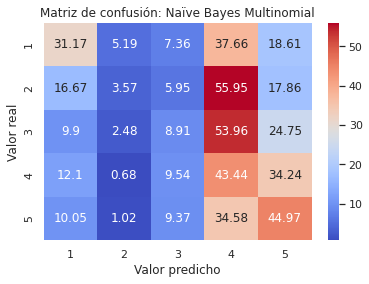

In [ ]:
# Gráfica matriz de confusión Multinomial Naïve Bayes en porcentajes
cm = metrics.confusion_matrix(ytest,modelos.predict(Xtest.astype(str)))
cm_percent = np.round(cm / cm.sum(axis=1)[:, np.newaxis] * 100, 2)

sns.set(font_scale = 1, color_codes = True, palette = 'deep')
sns.heatmap(cm_percent, cmap = "coolwarm", annot = True, fmt = 'g', xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.title('Matriz de confusión: Naïve Bayes Multinomial')
plt.xlabel('Valor predicho')
plt.ylabel('Valor real')

Text(30.5, 0.5, 'Valor real')

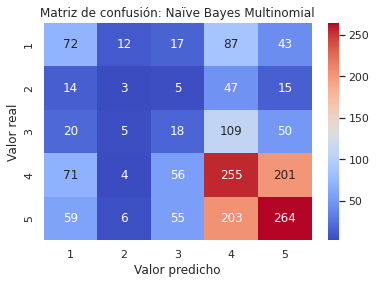

In [ ]:
# Gráfica matriz de confusión Multinomial Naïve Bayes

sns.set(font_scale = 1, color_codes = True, palette = 'deep')
sns.heatmap(cm, cmap = "coolwarm", annot = True, fmt = 'g',xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.title('Matriz de confusión: Naïve Bayes Multinomial')
plt.xlabel('Valor predicho')
plt.ylabel('Valor real')

#### Redes Neuronales

In [ ]:
from sklearn.neural_network import MLPClassifier

tokenizers = [TfidfVectorizer,CountVectorizer]
accTest = []

for tokenizer in tokenizers:
    modelo = Pipeline([('tokenizer', tokenizer()), ('modelo', MLPClassifier(random_state=1, max_iter=250))])
    # Se define el grid de parámetros a utilizar
        # Estos parámetros nos darán todas las posibles configuraciones del modelo
            # Cada combinación de híper-parámetros es una configuración diferente
    param_grid = {'tokenizer__max_df': max_df, 'tokenizer__min_df': min_df, 'modelo__hidden_layer_sizes': range(10, 26, 2), 'modelo__solver':['lbfgs', 'adam']}
    modelos = GridSearchCV(modelo, param_grid, scoring = 'f1_macro', cv = 4, return_train_score = True, n_jobs = -1)
    modelos.fit(Xtrain, ytrain)

    accTest.append(custom_accuracy(ytest, modelos.predict(Xtest.astype(str))))

# Crear una tabla panda para mostrarlo (lo vimos en la práctica de evaluación de modelos)
nombreColumnas = ['TfidfVectorizer', 'CountVectorizer']

datosPanda = pd.DataFrame(data=np.array(accTest).reshape(1, 2), index=['Precisiones'], columns=nombreColumnas)
# Establecemos el nombre de la columna index (valores de lambda)
datosPanda.index.name = 'Precisiones obtenidas'
# Mostramos el dataframe generado
print(datosPanda)

                       TfidfVectorizer  CountVectorizer
Precisiones obtenidas                                  
Precisiones                   0.401833         0.462153


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# Se muestra la mejor configuración y su accuracy asociado
print(modelos.best_params_)
print(modelos.best_score_)
# Almacenamos el DataFrame con los resultados
diccionarioResultados = modelos.cv_results_
# Se muestra el accuracy obtenido para cada posible combinación de parámetros
resultadosMostrar = zip(diccionarioResultados['params'],diccionarioResultados['mean_test_score'],diccionarioResultados['mean_train_score'])
for params, mean_test_score, mean_train_score in resultadosMostrar:
    print("%0.3f (Train: %0.3f) for %r" % (mean_test_score, mean_train_score, params))
    print()

# Se obtiene el rendimiento en test por la mejor configuración
print(f'La mejor precisión obtenida es: {np.max(accTest)} utilizando el tokenizador: {nombreColumnas[np.argmax(accTest)]}')
precisiones_count.append(accTest[0])
precisiones_tfidf.append(accTest[1])

{'modelo__hidden_layer_sizes': 24, 'modelo__solver': 'adam', 'tokenizer__max_df': 323, 'tokenizer__min_df': 14}
0.5306895753065011
0.381 (Train: 0.801) for {'modelo__hidden_layer_sizes': 10, 'modelo__solver': 'lbfgs', 'tokenizer__max_df': 378, 'tokenizer__min_df': 51}

0.416 (Train: 0.936) for {'modelo__hidden_layer_sizes': 10, 'modelo__solver': 'lbfgs', 'tokenizer__max_df': 378, 'tokenizer__min_df': 35}

0.421 (Train: 0.914) for {'modelo__hidden_layer_sizes': 10, 'modelo__solver': 'lbfgs', 'tokenizer__max_df': 378, 'tokenizer__min_df': 30}

0.433 (Train: 0.959) for {'modelo__hidden_layer_sizes': 10, 'modelo__solver': 'lbfgs', 'tokenizer__max_df': 378, 'tokenizer__min_df': 24}

0.465 (Train: 0.974) for {'modelo__hidden_layer_sizes': 10, 'modelo__solver': 'lbfgs', 'tokenizer__max_df': 378, 'tokenizer__min_df': 14}

0.389 (Train: 0.800) for {'modelo__hidden_layer_sizes': 10, 'modelo__solver': 'lbfgs', 'tokenizer__max_df': 323, 'tokenizer__min_df': 51}

0.407 (Train: 0.881) for {'modelo__

Text(30.5, 0.5, 'Valor real')

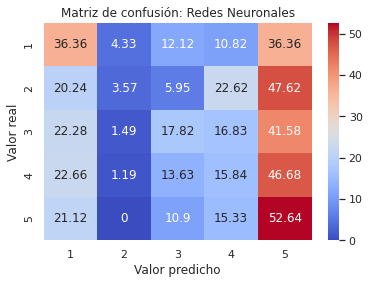

In [ ]:
# Gráfica matriz de confusión Redes Neuronales porcentajes
cm = metrics.confusion_matrix(ytest,modelos.predict(Xtest.astype(str)))
cm_percent = np.round(cm / cm.sum(axis=1)[:, np.newaxis] * 100, 2)

sns.set(font_scale = 1, color_codes = True, palette = 'deep')
sns.heatmap(cm_percent, cmap = "coolwarm", annot = True, fmt = 'g', xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.title('Matriz de confusión: Redes Neuronales')
plt.xlabel('Valor predicho')
plt.ylabel('Valor real')

Text(30.5, 0.5, 'Valor real')

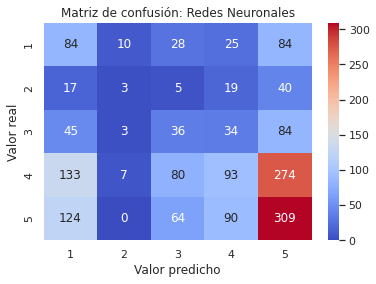

In [ ]:
# Gráfica matriz de confusión Redes Neuronales

sns.set(font_scale = 1, color_codes = True, palette = 'deep')
sns.heatmap(cm, cmap = "coolwarm", annot = True, fmt = 'g',xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.title('Matriz de confusión: Redes Neuronales')
plt.xlabel('Valor predicho')
plt.ylabel('Valor real')

#### Máquinas de vector soporte

In [ ]:
from sklearn.svm import SVC

tokenizers = [TfidfVectorizer,CountVectorizer]
accTest = []

for tokenizer in tokenizers:
    modelo = Pipeline([('tokenizer', tokenizer()), ('modelo', SVC())])
    # Se define el grid de parámetros a utilizar
        # Estos parámetros nos darán todas las posibles configuraciones del modelo
            # Cada combinación de híper-parámetros es una configuración diferente
    param_grid = {'tokenizer__max_df': max_df, 'tokenizer__min_df': min_df, 'modelo__C': [0.1, 1.0, 5.0, 10.0], 'modelo__gamma': [0.00025, 0.0005, 0.001, 0.01], 'modelo__kernel':['rbf', 'sigmoid']}
    modelos = GridSearchCV(modelo, param_grid, scoring = 'f1_macro', cv = 4, return_train_score = True, n_jobs = -1)
    modelos.fit(Xtrain, ytrain)

    accTest.append(custom_accuracy(ytest, modelos.predict(Xtest.astype(str))))

# Crear una tabla panda para mostrarlo (lo vimos en la práctica de evaluación de modelos)
nombreColumnas = ['TfidfVectorizer', 'CountVectorizer']

datosPanda = pd.DataFrame(data=np.array(accTest).reshape(1, 2), index=['Precisiones'], columns=nombreColumnas)
# Establecemos el nombre de la columna index (valores de lambda)
datosPanda.index.name = 'Precisiones obtenidas'
# Mostramos el dataframe generado
print(datosPanda)

                       TfidfVectorizer  CountVectorizer
Precisiones obtenidas                                  
Precisiones                   0.558841         0.527794


In [ ]:
# Se muestra la mejor configuración y su accuracy asociado
print(modelos.best_params_)
print(modelos.best_score_)
# Almacenamos el DataFrame con los resultados
diccionarioResultados = modelos.cv_results_
# Se muestra el accuracy obtenido para cada posible combinación de parámetros
resultadosMostrar = zip(diccionarioResultados['params'],diccionarioResultados['mean_test_score'],diccionarioResultados['mean_train_score'])
for params, mean_test_score, mean_train_score in resultadosMostrar:
    print("%0.3f (Train: %0.3f) for %r" % (mean_test_score, mean_train_score, params))
    print()

# Se obtiene el rendimiento en test por la mejor configuración
print(f'La mejor precisión obtenida es: {np.max(accTest)} utilizando el tokenizador: {nombreColumnas[np.argmax(accTest)]}')
precisiones_count.append(accTest[0])
precisiones_tfidf.append(accTest[1])

{'modelo__C': 10.0, 'modelo__gamma': 0.01, 'modelo__kernel': 'rbf', 'tokenizer__max_df': 378, 'tokenizer__min_df': 14}
0.4646809089537286
0.109 (Train: 0.114) for {'modelo__C': 0.1, 'modelo__gamma': 0.00025, 'modelo__kernel': 'rbf', 'tokenizer__max_df': 378, 'tokenizer__min_df': 51}

0.108 (Train: 0.114) for {'modelo__C': 0.1, 'modelo__gamma': 0.00025, 'modelo__kernel': 'rbf', 'tokenizer__max_df': 378, 'tokenizer__min_df': 35}

0.108 (Train: 0.115) for {'modelo__C': 0.1, 'modelo__gamma': 0.00025, 'modelo__kernel': 'rbf', 'tokenizer__max_df': 378, 'tokenizer__min_df': 30}

0.107 (Train: 0.116) for {'modelo__C': 0.1, 'modelo__gamma': 0.00025, 'modelo__kernel': 'rbf', 'tokenizer__max_df': 378, 'tokenizer__min_df': 24}

0.109 (Train: 0.115) for {'modelo__C': 0.1, 'modelo__gamma': 0.00025, 'modelo__kernel': 'rbf', 'tokenizer__max_df': 378, 'tokenizer__min_df': 14}

0.103 (Train: 0.109) for {'modelo__C': 0.1, 'modelo__gamma': 0.00025, 'modelo__kernel': 'rbf', 'tokenizer__max_df': 323, 'token

Text(30.5, 0.5, 'Valor real')

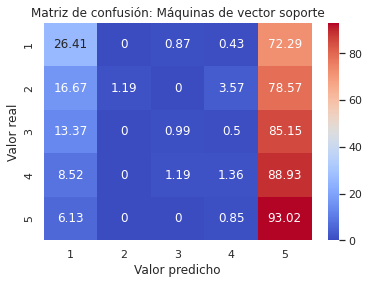

In [ ]:
# Gráfica matriz de confusión Máquinas de vector porcentajes
cm = metrics.confusion_matrix(ytest,modelos.predict(Xtest.astype(str)))
cm_percent = np.round(cm / cm.sum(axis=1)[:, np.newaxis] * 100, 2)

sns.set(font_scale = 1, color_codes = True, palette = 'deep')
sns.heatmap(cm_percent, cmap = "coolwarm", annot = True, fmt = 'g', xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.title('Matriz de confusión: Máquinas de vector soporte')
plt.xlabel('Valor predicho')
plt.ylabel('Valor real')

Text(30.5, 0.5, 'Valor real')

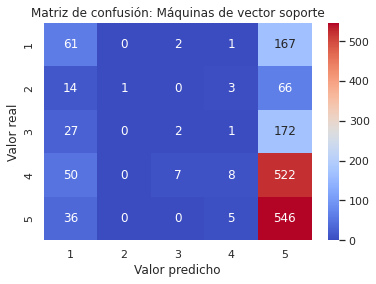

In [ ]:
# Gráfica matriz de confusión Máquinas de vector soporte

sns.set(font_scale = 1, color_codes = True, palette = 'deep')
sns.heatmap(cm, cmap = "coolwarm", annot = True, fmt = 'g',xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.title('Matriz de confusión: Máquinas de vector soporte')
plt.xlabel('Valor predicho')
plt.ylabel('Valor real')

#### Ensembles OVO | OVA

#### OVA

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

tokenizers = [TfidfVectorizer,CountVectorizer]
accTest = []

for tokenizer in tokenizers:
    modelo = Pipeline([('tokenizer', tokenizer()), ('modelo', OneVsRestClassifier(estimator=SVC()))])
    # Se define el grid de parámetros a utilizar
        # Estos parámetros nos darán todas las posibles configuraciones del modelo
            # Cada combinación de híper-parámetros es una configuración diferente
    param_grid = {'tokenizer__max_df': max_df, 'tokenizer__min_df': min_df}
    modelos = GridSearchCV(modelo, param_grid, scoring = 'f1_macro', cv = 4, return_train_score = True, n_jobs = -1)
    modelos.fit(Xtrain, ytrain)

    accTest.append(custom_accuracy(ytest, modelos.predict(Xtest.astype(str))))

# Crear una tabla panda para mostrarlo (lo vimos en la práctica de evaluación de modelos)
nombreColumnas = ['TfidfVectorizer', 'CountVectorizer']

datosPanda = pd.DataFrame(data=np.array(accTest).reshape(1, 2), index=['Precisiones'], columns=nombreColumnas)
# Establecemos el nombre de la columna index (valores de lambda)
datosPanda.index.name = 'Precisiones obtenidas'
# Mostramos el dataframe generado
print(datosPanda)

                       TfidfVectorizer  CountVectorizer
Precisiones obtenidas                                  
Precisiones                    0.43495         0.501183


In [ ]:
# Se muestra la mejor configuración y su accuracy asociado
print(modelos.best_params_)
print(modelos.best_score_)
# Almacenamos el DataFrame con los resultados
diccionarioResultados = modelos.cv_results_
# Se muestra el accuracy obtenido para cada posible combinación de parámetros
resultadosMostrar = zip(diccionarioResultados['params'],diccionarioResultados['mean_test_score'],diccionarioResultados['mean_train_score'])
for params, mean_test_score, mean_train_score in resultadosMostrar:
    print("%0.3f (Train: %0.3f) for %r" % (mean_test_score, mean_train_score, params))
    print()

# Se obtiene el rendimiento en test por la mejor configuración
print(f'La mejor precisión obtenida es: {np.max(accTest)} utilizando el tokenizador: {nombreColumnas[np.argmax(accTest)]}')
precisiones_count.append(accTest[0])
precisiones_tfidf.append(accTest[1])

{'tokenizer__max_df': 323, 'tokenizer__min_df': 14}
0.5529046265163132
0.444 (Train: 0.781) for {'tokenizer__max_df': 378, 'tokenizer__min_df': 51}

0.492 (Train: 0.830) for {'tokenizer__max_df': 378, 'tokenizer__min_df': 35}

0.498 (Train: 0.846) for {'tokenizer__max_df': 378, 'tokenizer__min_df': 30}

0.504 (Train: 0.868) for {'tokenizer__max_df': 378, 'tokenizer__min_df': 24}

0.533 (Train: 0.892) for {'tokenizer__max_df': 378, 'tokenizer__min_df': 14}

0.453 (Train: 0.788) for {'tokenizer__max_df': 323, 'tokenizer__min_df': 51}

0.493 (Train: 0.835) for {'tokenizer__max_df': 323, 'tokenizer__min_df': 35}

0.497 (Train: 0.851) for {'tokenizer__max_df': 323, 'tokenizer__min_df': 30}

0.510 (Train: 0.871) for {'tokenizer__max_df': 323, 'tokenizer__min_df': 24}

0.553 (Train: 0.894) for {'tokenizer__max_df': 323, 'tokenizer__min_df': 14}

0.450 (Train: 0.785) for {'tokenizer__max_df': 271, 'tokenizer__min_df': 51}

0.482 (Train: 0.842) for {'tokenizer__max_df': 271, 'tokenizer__min_df'

Text(30.5, 0.5, 'Valor real')

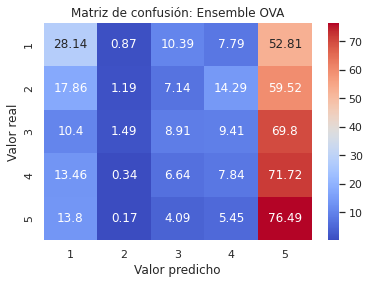

In [ ]:
# Gráfica matriz de confusión OVA en porcentajes
cm = metrics.confusion_matrix(ytest,modelos.predict(Xtest.astype(str)))
cm_percent = np.round(cm / cm.sum(axis=1)[:, np.newaxis] * 100, 2)

sns.set(font_scale = 1, color_codes = True, palette = 'deep')
sns.heatmap(cm_percent, cmap = "coolwarm", annot = True, fmt = 'g', xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.title('Matriz de confusión: Ensemble OVA')
plt.xlabel('Valor predicho')
plt.ylabel('Valor real')

Text(30.5, 0.5, 'Valor real')

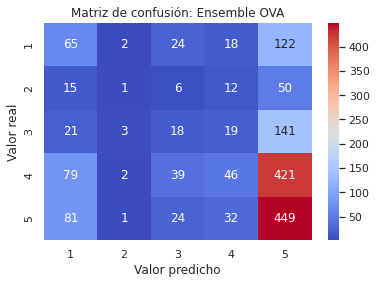

In [ ]:
# Gráfica matriz de confusión Ensembles OVA

sns.set(font_scale = 1, color_codes = True, palette = 'deep')
sns.heatmap(cm, cmap = "coolwarm", annot = True, fmt = 'g',xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.title('Matriz de confusión: Ensemble OVA')
plt.xlabel('Valor predicho')
plt.ylabel('Valor real')

#### OVO

In [ ]:
from sklearn.multiclass import OneVsOneClassifier

tokenizers = [TfidfVectorizer,CountVectorizer]
accTest = []

for tokenizer in tokenizers:
    modelo = Pipeline([('tokenizer', tokenizer()), ('modelo', OneVsOneClassifier(estimator=SVC()))])
    # Se define el grid de parámetros a utilizar
        # Estos parámetros nos darán todas las posibles configuraciones del modelo
            # Cada combinación de híper-parámetros es una configuración diferente
    param_grid = {'tokenizer__max_df': max_df, 'tokenizer__min_df': min_df}
    modelos = GridSearchCV(modelo, param_grid, scoring = 'f1_macro', cv = 4, return_train_score = True, n_jobs = -1)
    modelos.fit(Xtrain, ytrain)

    accTest.append(custom_accuracy(ytest, modelos.predict(Xtest.astype(str))))

# Crear una tabla panda para mostrarlo (lo vimos en la práctica de evaluación de modelos)
nombreColumnas = ['TfidfVectorizer', 'CountVectorizer']

datosPanda = pd.DataFrame(data=np.array(accTest).reshape(1, 2), index=['Precisiones'], columns=nombreColumnas)
# Establecemos el nombre de la columna index (valores de lambda)
datosPanda.index.name = 'Precisiones obtenidas'
# Mostramos el dataframe generado
print(datosPanda)

                       TfidfVectorizer  CountVectorizer
Precisiones obtenidas                                  
Precisiones                   0.508575         0.535186


In [ ]:
# Se muestra la mejor configuración y su accuracy asociado
print(modelos.best_params_)
print(modelos.best_score_)
# Almacenamos el DataFrame con los resultados
diccionarioResultados = modelos.cv_results_
# Se muestra el accuracy obtenido para cada posible combinación de parámetros
resultadosMostrar = zip(diccionarioResultados['params'],diccionarioResultados['mean_test_score'],diccionarioResultados['mean_train_score'])
for params, mean_test_score, mean_train_score in resultadosMostrar:
    print("%0.3f (Train: %0.3f) for %r" % (mean_test_score, mean_train_score, params))
    print()

# Se obtiene el rendimiento en test por la mejor configuración
print(f'La mejor precisión obtenida es: {np.max(accTest)} utilizando el tokenizador: {nombreColumnas[np.argmax(accTest)]}')
precisiones_count.append(accTest[0])
precisiones_tfidf.append(accTest[1])

{'tokenizer__max_df': 323, 'tokenizer__min_df': 14}
0.43494801633422375
0.370 (Train: 0.566) for {'tokenizer__max_df': 378, 'tokenizer__min_df': 51}

0.404 (Train: 0.622) for {'tokenizer__max_df': 378, 'tokenizer__min_df': 35}

0.406 (Train: 0.636) for {'tokenizer__max_df': 378, 'tokenizer__min_df': 30}

0.413 (Train: 0.651) for {'tokenizer__max_df': 378, 'tokenizer__min_df': 24}

0.420 (Train: 0.693) for {'tokenizer__max_df': 378, 'tokenizer__min_df': 14}

0.389 (Train: 0.589) for {'tokenizer__max_df': 323, 'tokenizer__min_df': 51}

0.412 (Train: 0.661) for {'tokenizer__max_df': 323, 'tokenizer__min_df': 35}

0.426 (Train: 0.678) for {'tokenizer__max_df': 323, 'tokenizer__min_df': 30}

0.425 (Train: 0.691) for {'tokenizer__max_df': 323, 'tokenizer__min_df': 24}

0.435 (Train: 0.720) for {'tokenizer__max_df': 323, 'tokenizer__min_df': 14}

0.381 (Train: 0.644) for {'tokenizer__max_df': 271, 'tokenizer__min_df': 51}

0.396 (Train: 0.698) for {'tokenizer__max_df': 271, 'tokenizer__min_df

Text(30.5, 0.5, 'Valor real')

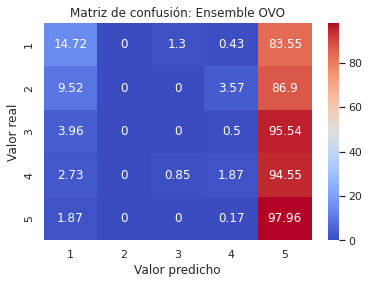

In [ ]:
# Gráfica matriz de confusión OVO en porcentajes
cm = metrics.confusion_matrix(ytest,modelos.predict(Xtest.astype(str)))
cm_percent = np.round(cm / cm.sum(axis=1)[:, np.newaxis] * 100, 2)

sns.set(font_scale = 1, color_codes = True, palette = 'deep')
sns.heatmap(cm_percent, cmap = "coolwarm", annot = True, fmt = 'g', xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.title('Matriz de confusión: Ensemble OVO')
plt.xlabel('Valor predicho')
plt.ylabel('Valor real')

Text(30.5, 0.5, 'Valor real')

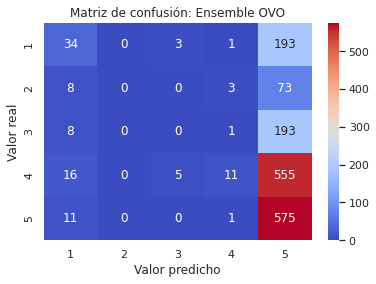

In [ ]:
# Gráfica matriz de confusión Ensembles OVO

sns.set(font_scale = 1, color_codes = True, palette = 'deep')
sns.heatmap(cm, cmap = "coolwarm", annot = True, fmt = 'g',xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.title('Matriz de confusión: Ensemble OVO')
plt.xlabel('Valor predicho')
plt.ylabel('Valor real')

#### Ensembles DecisionTree, Bagging, Boosting y Random Forest

In [ ]:
# # DecisionTreeClassifier no soporta strings


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn import metrics




tokenizers = [TfidfVectorizer,CountVectorizer]
todos_modelos = []
clasificadores = [
    DecisionTreeClassifier(criterion='entropy', random_state=12),
    BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy'), n_estimators=15, random_state=12),
    AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy'), n_estimators=15, random_state=12),
    RandomForestClassifier(criterion='entropy', max_features='log2', n_estimators=15, random_state=12)
]

nombres = ['DecisionTree', 'Bagging', 'Boosting', 'RandomForest']
accTest = []
for j, vectorizer in enumerate(tokenizers):
  for i, clasificador in enumerate(clasificadores):
    modelo = Pipeline([('tokenizer', tokenizer()), ('modelo', clasificador)])
    param_grid = {'tokenizer__max_df': max_df, 'tokenizer__min_df': min_df}
    modelos = GridSearchCV(modelo, param_grid, scoring = 'f1_macro', cv = 4, return_train_score = True, n_jobs = -1)
    modelos.fit(Xtrain, ytrain)
    todos_modelos.append(modelos)
    accTest.append(custom_accuracy(ytest, modelos.predict(Xtest.astype(str))))

# Crear una tabla panda para mostrarlo (lo vimos en la práctica de evaluación de modelos)
nombreColumnas = ['TfidfVectorizer', 'CountVectorizer']

accuracys = np.array(accTest).reshape(4, 2)
datosPanda = pd.DataFrame(data=accuracys, index=nombres, columns=nombreColumnas)
# Establecemos el nombre de la columna index (valores de lambda)
datosPanda.index.name = 'Precisiones obtenidas'
# Mostramos el dataframe generado
print(datosPanda)



                       TfidfVectorizer  CountVectorizer
Precisiones obtenidas                                  
DecisionTree                  0.453873         0.444116
Bagging                       0.457126         0.468953
Boosting                      0.453873         0.444116
RandomForest                  0.457126         0.468953


In [ ]:
# Se obtiene el rendimiento en test por la mejor configuración
print(f'La mejor precisión obtenida es: {np.max(accTest)} utilizando el tokenizador: {nombreColumnas[np.where(np.round(accuracys,2) == np.round(np.max(accuracys),2))[0][0]]} y el modelo: {nombres[np.where(np.round(accuracys,2) == np.round(np.max(accuracys),2))[0][1]]}')
precisiones_count.append(accTest[0])
precisiones_tfidf.append(accTest[1])

La mejor precisión obtenida es: 0.4689532820816085 utilizando el tokenizador: CountVectorizer y el modelo: RandomForest


Text(30.5, 0.5, 'Valor real')

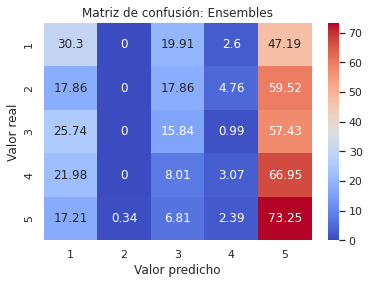

In [ ]:
# Gráfica matriz de confusión OVO en porcentajes
cm = metrics.confusion_matrix(ytest,todos_modelos[np.argmax(accTest)].predict(Xtest.astype(str)))
cm_percent = np.round(cm / cm.sum(axis=1)[:, np.newaxis] * 100, 2)

sns.set(font_scale = 1, color_codes = True, palette = 'deep')
sns.heatmap(cm_percent, cmap = "coolwarm", annot = True, fmt = 'g', xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.title('Matriz de confusión: Ensembles')
plt.xlabel('Valor predicho')
plt.ylabel('Valor real')

Text(30.5, 0.5, 'Valor real')

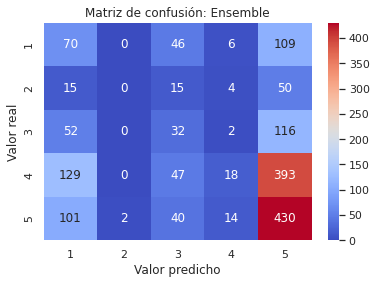

In [ ]:
# Gráfica matriz de confusión Ensembles

sns.set(font_scale = 1, color_codes = True, palette = 'deep')
sns.heatmap(cm, cmap = "coolwarm", annot = True, fmt = 'g',xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.title('Matriz de confusión: Ensemble')
plt.xlabel('Valor predicho')
plt.ylabel('Valor real')

### Resultados

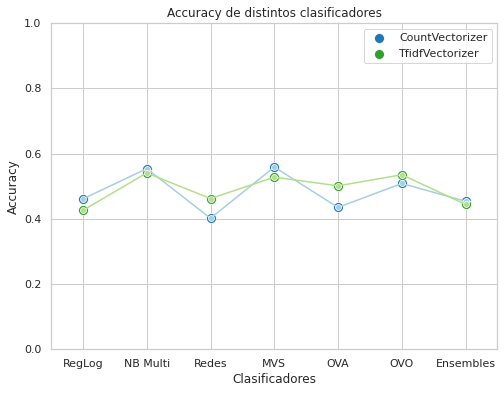

In [ ]:
## Creamos una gráfica con las precisiones obtenidas en los distintos clasificadores para los dos vectorizadores.
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
colors = sns.color_palette("Paired")

# Precisiones para CountVectorizer
sns.lineplot(x=["RegLog", "NB Multi", "Redes", "MVS", "OVA", "OVO", "Ensembles"], y=precisiones_count, markers=True, marker="o", color=colors[0])
sns.scatterplot(x=["RegLog", "NB Multi", "Redes", "MVS", "OVA", "OVO", "Ensembles"], y=precisiones_count, s=100, color=colors[1], label="CountVectorizer")

# Precisiones para TfidfVectorizer
sns.lineplot(x=["RegLog", "NB Multi", "Redes", "MVS", "OVA", "OVO", "Ensembles"], y=precisiones_tfidf, markers=True, marker="o", color=colors[2])
sns.scatterplot(x=["RegLog", "NB Multi", "Redes", "MVS", "OVA", "OVO", "Ensembles"], y=precisiones_tfidf, s=100, color=colors[3], label="TfidfVectorizer")

plt.title("Accuracy de distintos clasificadores")
plt.xlabel("Clasificadores")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xlim(-0.5, 6.5)
plt.legend()
plt.show()